In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("data/rent.csv")
df_num = df[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'price']].copy()
df_num = df_num[(df_num['latitude']>40.55) & (df_num['latitude']<40.94) &
                (df_num['longitude']>-74.1) & (df_num['longitude']<-73.67)]

df_num = df_num[(df_num.price>1_000) & (df_num.price<10_000)]

df_train, df_test = train_test_split(df_num, test_size=0.2)
X_train = df_train[['bedrooms','bathrooms','latitude','longitude']]
y_train = df_train['price']
X_test = df_test[['bedrooms','bathrooms','latitude','longitude']]
y_test = df_test['price']

rf = RandomForestRegressor(oob_score=True, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [5]:
X_test.shape, X_train.shape

((9660, 4), (38640, 4))

CPU times: user 473 ms, sys: 2.47 ms, total: 476 ms
Wall time: 477 ms
CPU times: user 831 ms, sys: 3.19 ms, total: 835 ms
Wall time: 839 ms


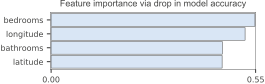

In [6]:
%time I = importances(rf, X_test, y_test)
viz = plot_importances(I)
#viz.save()

# Permutation importance with test set

In [7]:
scores = []
n_range = np.arange(10,len(X_test),300)
full_I = importances(rf, X_test, y_test)
for n in n_range:
    I = importances(rf, X_test, y_test, n_samples=n)
    e = mean_absolute_error(I.sort_index().Importance,full_I.sort_index().Importance)
    scores.append(e)
    print(f"MAE between subsample and full test importance n_samples={n}: {e:.4f}")

MAE between subsample and full test importance n_samples=10: 0.2102
MAE between subsample and full test importance n_samples=310: 0.0660
MAE between subsample and full test importance n_samples=610: 0.0109
MAE between subsample and full test importance n_samples=910: 0.0253
MAE between subsample and full test importance n_samples=1210: 0.0164
MAE between subsample and full test importance n_samples=1510: 0.0528
MAE between subsample and full test importance n_samples=1810: 0.0356
MAE between subsample and full test importance n_samples=2110: 0.0260
MAE between subsample and full test importance n_samples=2410: 0.0238
MAE between subsample and full test importance n_samples=2710: 0.0294
MAE between subsample and full test importance n_samples=3010: 0.0304
MAE between subsample and full test importance n_samples=3310: 0.0184
MAE between subsample and full test importance n_samples=3610: 0.0066
MAE between subsample and full test importance n_samples=3910: 0.0139
MAE between subsample and

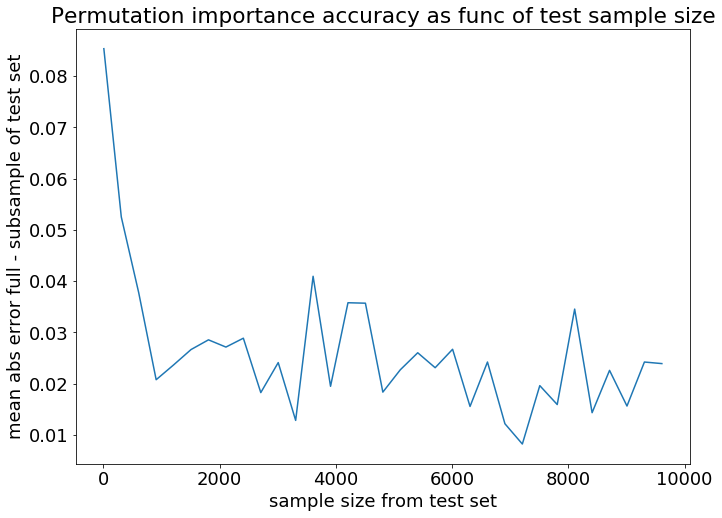

In [27]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (11,8)
rcParams["font.size"] = "18"
plt.plot(n_range, scores)
plt.ylabel("mean abs error full - subsample of test set")
plt.xlabel("sample size from test set")
plt.title("Permutation importance accuracy as func of test sample size")
plt.savefig("/tmp/rent-pimp-sample-size.svg")
plt.show()

# Permutation importance using cross validation

CPU times: user 2min 52s, sys: 8.06 s, total: 3min
Wall time: 31.7 s


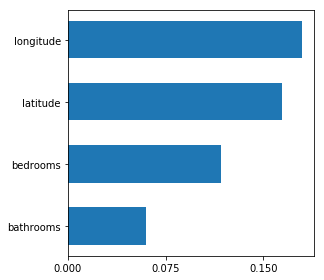

In [22]:
%time I = cv_importances(rf, X_train, y_train, k=5)
plot_importances(I)

# Drop-column

CPU times: user 19.4 s, sys: 580 ms, total: 20 s
Wall time: 20.2 s


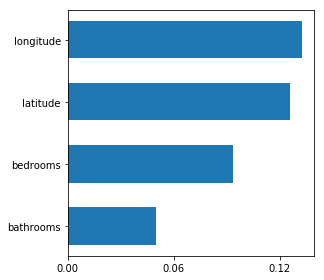

In [20]:
rf = RandomForestRegressor(oob_score=True, n_estimators=100)
%time I = dropcol_importances(rf, X_train, y_train)
plot_importances(I)

# Eli5

CPU times: user 4.76 s, sys: 176 ms, total: 4.93 s
Wall time: 2.22 s


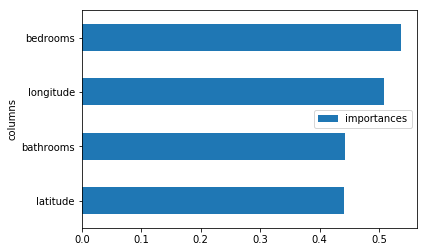

In [21]:
from eli5.sklearn import PermutationImportance
import eli5

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

%time perm = PermutationImportance(rf).fit(X_test, y_test)
I = pd.DataFrame(data={"columns":X_test.columns, "importances":perm.feature_importances_})
I = I.set_index("columns")
I = I.sort_values('importances', ascending=True)
I.plot.barh()